# [hotsline](https://github.com/AntoineGrimaldi/hotsline) algorithm to replicate results from [this paper](https://www.techrxiv.org/articles/preprint/A_robust_event-driven_approach_to_always-on_object_recognition/18003077/1)
## Load events of the NMNIST dataset with [Tonic](https://tonic.readthedocs.io/en/latest/index.html)

In [3]:
import tonic, torch, os
%cd ../hots
from utils import get_loader, get_dataset_info, HOTS_Dataset, make_histogram_classification
from network import network
from timesurface import timesurface

print(f' Tonic version installed -> {tonic.__version__}')

transform = tonic.transforms.NumpyAsType(int)
dataset = tonic.datasets.NMNIST(save_to='../../Data/', train=True, transform=transform)
#get_dataset_info(dataset, properties = ['time', 'mean_isi', 'nb_events']);
print(f'number of samples in the dataset: {len(dataset)}')

/home/antoine/homhots/hotsline/hots
 Tonic version installed -> 1.0.15
number of samples in the dataset: 60000


In [18]:
transform = tonic.transforms.NumpyAsType(int)
trainset = tonic.datasets.NMNIST(save_to='../../Data/', train=True, transform=transform, first_saccade_only=True)
testset = tonic.datasets.NMNIST(save_to='../../Data/', train=False, transform=transform, first_saccade_only=True)

name = 'homeohots'
homeo = True
timestr = '2022-04-22'
dataset_name = 'nmnist'

R_first = [2]
N_layers = [2]
n_first = [16]
tau_first = [1e4]

scores, parameters = [], []

for lay in N_layers:
    for R in R_first:
        for tau in tau_first:
            for N_neuron in n_first:
                Rz = [R*2**Nl for Nl in range(lay)]
                N_neuronz = [N_neuron*2**Nl for Nl in range(lay)]
                N_pola = N_neuronz.copy()
                N_pola.insert(0,2)
                tauz = [tau*N_pola[Nl] for Nl in range(lay)]
                hots = network(name, dataset_name, timestr, trainset.sensor_size, nb_neurons = N_neuronz, tau = tauz, R = Rz, homeo = homeo)
                print(hots.name)
                filtering_threshold = [2*Rz[L] for L in range(len(Rz))]
                #clustering
                loader = get_loader(trainset, kfold = 300)
                hots.clustering(loader, trainset.ordering, filtering_threshold)
                #training
                loader = get_loader(trainset, kfold = 60)
                num_sample_train = len(loader)
                hots.coding(loader, trainset.ordering, trainset.classes, filtering_threshold, training=True)
                #testing
                loader = get_loader(testset, kfold = 60)
                num_sample_test = len(loader)
                hots.coding(loader, trainset.ordering, trainset.classes, filtering_threshold, training=False)
                jitter = (None, None)

                train_path = f'../Records/output/train/{hots.name}_{num_sample_train}_{jitter}/'
                test_path = f'../Records/output/test/{hots.name}_{num_sample_test}_{jitter}/'

                testset_output = HOTS_Dataset(test_path, trainset.sensor_size, transform=transform, dtype=trainset.dtype)
                trainset_output = HOTS_Dataset(train_path, trainset.sensor_size, transform=transform, dtype=trainset.dtype)
                
                score = make_histogram_classification(trainset_output, testset_output, N_neuronz[-1]) 
                
                scores.append(score)
                parameters.append([lay, R, tau, N_neuron])

device -> cuda
2022-04-22_nmnist_homeohots_True_[16, 32]_[20000.0, 160000.0]_[2, 4]
this dataset have already been processed, check at: 
 ../Records/output/train/2022-04-22_nmnist_homeohots_True_[16, 32]_[20000.0, 160000.0]_[2, 4]_1000_(None, None)/
this dataset have already been processed, check at: 
 ../Records/output/test/2022-04-22_nmnist_homeohots_True_[16, 32]_[20000.0, 160000.0]_[2, 4]_160_(None, None)/


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 160/160 [00:00<00:00, 820.89it/s]


In [15]:
import matplotlib.pyplot as plt
import copy

def plot_accuracy(scores, parameters, param_to_plot):
    paramlist = ['number of layers', 'R', 'tau', 'number of neurons']
    fig, ax = plt.subplots(figsize=(10,6))
    score_previous = 0
    for ind in range(len(scores)):
        score, tau, n_layer, R, n_neurons = scores[ind], parameters[ind][2], parameters[ind][0], parameters[ind][1], parameters[ind][3]
        if param_to_plot=='tau':
            x = copy.copy(tau)
        elif param_to_plot=='R':
            x = copy.copy(R)
        elif param_to_plot=='neuron':
            x = copy.copy(n_neurons)
        elif param_to_plot=='layer':
            x = copy.copy(n_layer)
        
        ax.plot(x, score, '*', color='blue')
        if n_layer==2 and R==2:
            ax.plot(x, score, '*', color='red')
        if n_layer==2 and R==4:
            ax.plot(x, score, '*', color='green')
        if n_layer==2 and R==3:
            ax.plot(x, score, '*', color='orange')

        ax.set_xlabel(param_to_plot)
        ax.set_ylabel('accuracy')
        if score>score_previous:
            score_previous=score
            parameters_previous=parameters[ind]
    print(score_previous, parameters_previous)
    
def plot_accuracy_multi_param(scores, parameters):
    fig = plt.figure(figsize=(30,10))
    sub1 = fig.add_subplot(1,3,1, projection="3d")
    sub2 = fig.add_subplot(1,3,2, projection="3d")
    sub3 = fig.add_subplot(1,3,3, projection="3d")
    score_previous = 0
    colormap = plt.cm.get_cmap('summer_r', 10);
    for ind in range(len(scores)):
        score, lay, n_neuron, R = scores[ind], parameters[ind][0], parameters[ind][3], parameters[ind][1]
        sub1.scatter(n_neuron, lay, score, color=colormap(R/4), alpha=0.5)
        sub2.scatter(R, lay, score, color=colormap(n_neuron/16), alpha=0.5)
        sub3.scatter(n_neuron, R, score, color=colormap(lay/4), alpha=0.5)
        sub1.set_xlabel('neuron number')
        sub2.set_xlabel('R')
        sub3.set_xlabel('neuron number')
        sub1.set_ylabel('layer number')
        sub2.set_ylabel('layer number')
        sub3.set_ylabel('R')
        #sub1.view_init(10,-40)

0.83125 [2, 2, 10000.0, 16]
0.83125 [2, 2, 10000.0, 16]
0.83125 [2, 2, 10000.0, 16]
0.83125 [2, 2, 10000.0, 16]


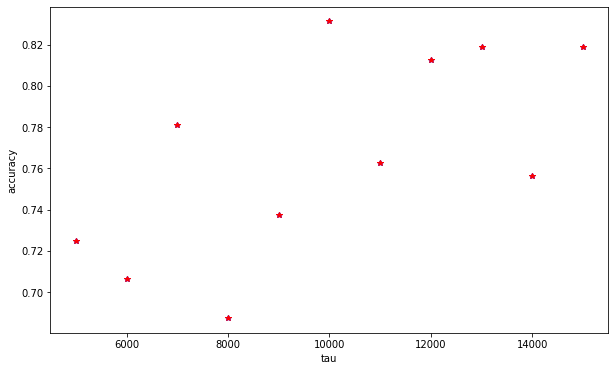

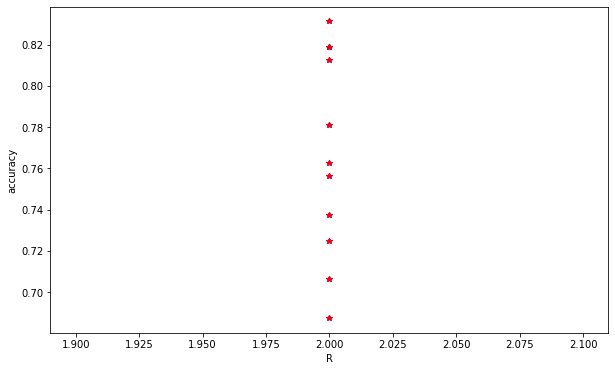

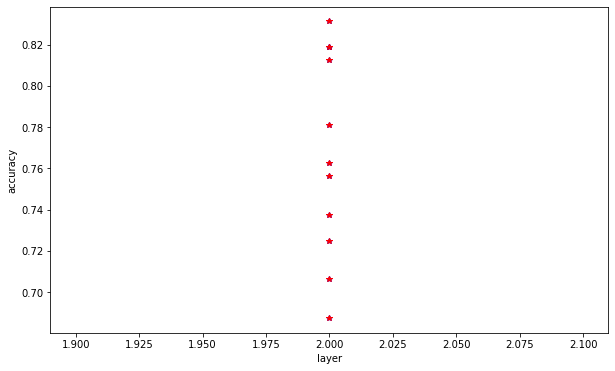

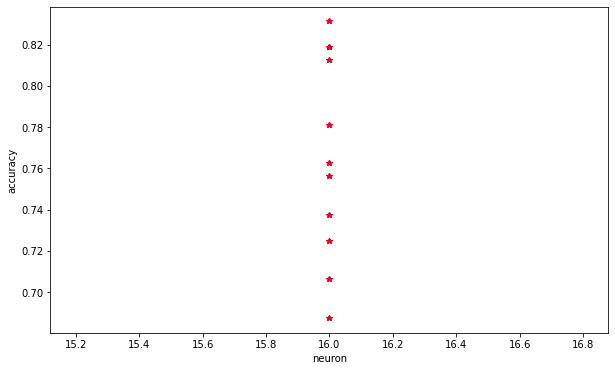

In [17]:
plot_accuracy(scores, parameters, 'tau')
plot_accuracy(scores, parameters, 'R')
plot_accuracy(scores, parameters, 'layer')
plot_accuracy(scores, parameters, 'neuron')